# Examples for torchRPM

We give two simple examples for basic usage of the RPM package in pytorch:
- 2D Gaussian Copula: we fit a standard RPM with Gaussian latent variables and a closed-form variational posterior $q(Z|X)$.
- Peer-supervision on MNIST: we reproduce the peer-supervision task from the original RPM paper [1], wherein an RPM with discrete latents is meant to learn to correlate images of hand-written digits that display the same digit, thus learning to classify them.

[1]  Walker, William I., et al. "Unsupervised representation learning with recognition-parametrised probabilistic models." International Conference on Artificial Intelligence and Statistics. PMLR, 2023.

# 2D Gaussian Copula
- We fit an RPM $p_\theta(X,Z)$ with continous latent variable $Z$ to a target distribution $p(X)$ given a copula, using variational inference.
- Copulas are a simple toy examples, and relevant to the RPM due to their strong similarities to RPMs.
- We use a Gaussian copula with exponential marginals, and $J=2$ univariate marginals. We stick to 2D for plotting.
- Rather than specify a variational family $q(Z|X)$ for the posterior approximation, we make an assumption $\forall j: F_j(Z) = p(Z)$ during training, which makes $q(Z|X)$ closed-form without any variational parameters ($q$ is fully specified by RPM model parameter $\theta$) . We check how badly this assumption is violated at the end of training.

In [1]:
import torch
import numpy as np

import rpm 
import recognition_nets
from expFam import LogPartition_gauss1D, ExpFam, ConditionalExpFam
from implicitRPM import GaussianCopula_ExponentialMarginals

np.random.seed(1)
torch.manual_seed(1)

J = 2                           # two marginals 
dim_js = [1 for j in range(J)]  # dimensions of marginals
dim_Z = 1                       # dimension of latent
dim_T = 2                       # dimension of sufficient statistics
N = 1000                        # number of datapoints for fitting

#  Gaussian copula with exponential marginals
rates = [1.0, 0.5]  # exponential distribution rate parameters for x1, x2
P = np.array([[1.0, -0.85], [-0.85, 1.0]]) # Gaussian copula correlation matrix
px = GaussianCopula_ExponentialMarginals(P=P, rates=rates, dims=dim_js)
xjs = px.sample_n(N)
pxjs = rpm.RPMEmpiricalMarginals(xjs) 

# define Gaussian prior in natural parametrization  
log_partition = LogPartition_gauss1D()
def activation_out(x,d=1): # NN returns natural parameters; in Gaussian case, that is m/sig2, -1/(2*sig2)
    return torch.cat([x[:,:d], -torch.nn.Softplus()(x[:,d:])],axis=-1)
latent_prior = ExpFam(natparam=torch.normal(mean=0.0, std=torch.ones(dim_T).reshape(1,-1)),
                      log_partition=log_partition, activation_out=activation_out)

# define Gaussian factors fj(Z|xj) in natural parametrization  
Net = recognition_nets.Net_3xFCRelu
natparam_models = [Net(dim_js[j], dim_T, n_hidden=10, activation_out=activation_out) for j in range(J)]
rec_models = [ConditionalExpFam(model=m, log_partition=log_partition) for m in natparam_models]

# instantiate RPM
model = rpm.RPM(rec_factors=rec_models, latent_prior=latent_prior, px=pxjs, q='use_theta', nu=None, iviNatParametrization='classic',
                stack_xjs_new_axis=True, full_N_for_Fj=True)


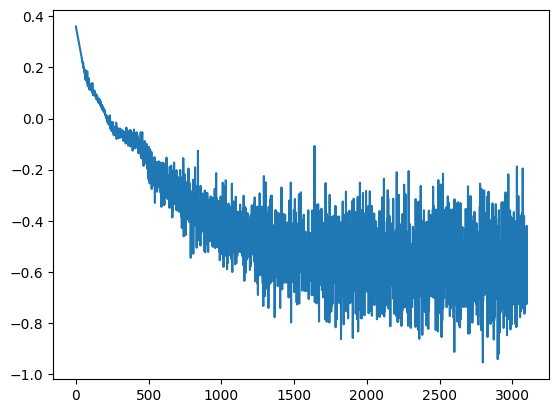

In [2]:
import matplotlib.pyplot as plt

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
epochs = 100
batch_size = 32

ds = torch.utils.data.TensorDataset(*xjs, torch.arange(N))
dl = torch.utils.data.DataLoader(dataset=ds, batch_size=batch_size, shuffle=True, drop_last=True)

ls,t = np.zeros(epochs*(N//batch_size)),0
for i in range(epochs):
    for batch in dl:
        optimizer.zero_grad()
        loss = model.training_step(batch=batch[:-1], idx_data=batch[-1], batch_idx=t)
        loss.backward()
        optimizer.step()
        ls[t] = loss.detach().numpy()
        t+=1
plt.plot(ls)
plt.show()


C:\Users\marce\miniconda3\envs\test_rpm\Lib\site-packages\torch\functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ..\aten\src\ATen\native\TensorShape.cpp:3550.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


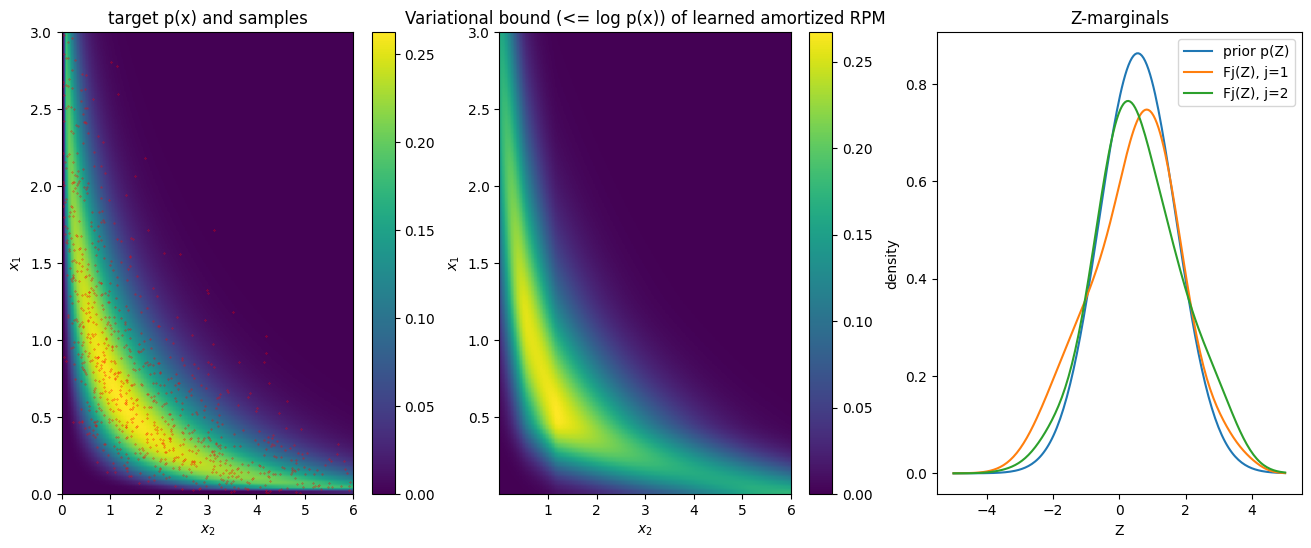

In [3]:
from sklearn.neighbors import KernelDensity

xxs = [torch.linspace(0.001, 3/rates[j],100) for j in range(J)]
XX,YY = torch.meshgrid(*xxs)
xgrid = torch.stack([XX.flatten(), YY.flatten()], axis=-1)
xgrid = xgrid.reshape(*xgrid.shape, 1)
log_p0 = torch.log(torch.Tensor(rates)[0]) - rates[0] * xxs[0].reshape(-1,1) + torch.log(torch.Tensor(rates)[1]) - rates[1] * xxs[1].reshape(1,-1)
log_w = model.elbo_innervi__q_theta([xgrid[:,j] for j in range(J)]).reshape(100,100)
logpx = log_w + log_p0 # we use the free energy-based variational objective as an estimate - strictly speaking this is a lower bound to log p(x) !

plt.figure(figsize=(16,6))
plt.subplot(1,3,1)
try: 
    logpx_true = px.log_probs(xgrid.detach().numpy().squeeze(-1)).reshape(100,100)
    plt.imshow(np.exp(logpx_true), origin='lower', 
               extent=(xgrid[:,1].min(), xgrid[:,1].max(), xgrid[:,0].min(), xgrid[:,0].max()), aspect='auto')
    plt.plot(xjs[1], xjs[0], 'r.', markersize=0.5)
    plt.axis((0., 3/rates[1], 0., 3/rates[0]))
    plt.colorbar()
except:
    plt.plot(xjs[0], xjs[1], '.')
plt.ylabel(r'$x_1$')
plt.xlabel(r'$x_2$')
plt.title('target p(x) and samples')
    
plt.subplot(1,3,2)
plt.imshow(np.exp(logpx.detach().numpy()), origin='lower', 
           extent=(xgrid[:,1].min(), xgrid[:,1].max(), xgrid[:,0].min(), xgrid[:,0].max()), aspect='auto')
#plt.axis((0., 3/rates[1], 0., 3/rates[0]))
plt.ylabel(r'$x_1$')
plt.xlabel(r'$x_2$')
plt.title('Variational bound (<= log p(x)) of learned amortized RPM')
plt.colorbar()

plt.subplot(1,3,3)
etajs_all = model.factorNatParams() # N-by-J-by-T
rec_factors, prior = model.joint_model[0], model.joint_model[1]
phijs_all = torch.stack([rec_factors[j].log_partition(etajs_all[:,j]) for j in range(model.J)],axis=1)
eta0 = prior.nat_param
phi0 = prior.phi()

Z = torch.linspace(-5, 5, 200)
tZ = torch.stack([Z, Z**2], axis=1)
pZ = torch.exp((eta0 * tZ).sum(axis=-1) - phi0)
plt.plot(Z.detach().numpy(), pZ.detach().numpy(), label='prior p(Z)')

for j in range(J):
    etaj_all = etajs_all[:,j]
    phij_all = phijs_all[:,j]
    fj = torch.exp((etaj_all.unsqueeze(0) * tZ.unsqueeze(1)).sum(axis=-1) - phij_all.unsqueeze(0))
    Fj = fj.mean(axis=1)
    plt.plot(Z.detach().numpy(), Fj.detach().numpy(), label='Fj(Z), j='+str(j+1))
plt.xlabel('Z')
plt.ylabel('density')
plt.title('Z-marginals')
plt.legend()

plt.show()

# Peer-supervision on MNIST
- we reproduce the peer-supervision task from the original RPM publication [1]
- data $X^n=[x_1^n,x_2^n]$ consists of pairs of MNIST images $x_j^n, j=1,2$ depicting the same digit $k^n = 1, \ldots, 10$.
- we train the RPM with conditional categorical recognition factors $f(Z|x_j)$ parametrized by convolutional neural networks.
- $N=60000$ in this case, making a compution every gradient step of the full normalization factors $F_{\theta_j}(Z) = 1/N \sum_n f(Z|x_j^n)$ infeasible. We instead use minibatch averages to approximate $F_{\theta_j}(Z), j=1,2$ on the fly.

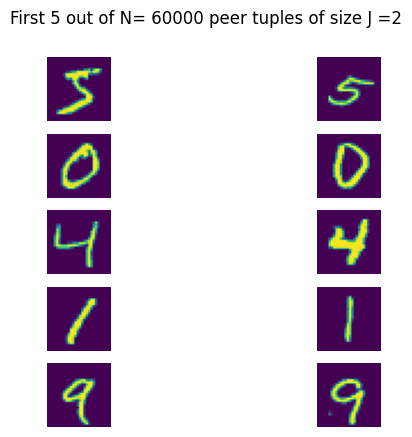

In [4]:
import torchvision
import torch

import matplotlib.pyplot as plt
import numpy as np

root = './data/MNIST'
ds0train = torchvision.datasets.MNIST(root=root, train=True)
ds0test = torchvision.datasets.MNIST(root=root, train=False)

class Peersupervision(torch.utils.data.Dataset):
    def __init__(self, data, targets, J, ifstack=True):
        self.data = data
        self.targets = targets.detach().numpy()
        self.J = J
        self.ifstack = ifstack
    def __len__(self):
        return len(self.data)
    def __getitem__(self,idx):
        c = self.targets[idx]
        if c.ndim==0:
            idc = np.where(self.targets==c)[0]
            pair_ids = idc[np.random.choice(len(idc), self.J+1, replace=False).reshape(1,-1)]
            pair_ids[0,0] = idx
        else:
            pair_ids = np.zeros((len(idx), self.J))
            for i,c_ in enumerate(c):
                idc = np.where(self.targets==c_)[0]
                pair_ids[i] = idc[np.random.choice(len(idc), self.J, replace=False)]
            pair_ids[:,0] = idx

        out = [self.data[pair_ids[:,j]] for j in range(self.J)]
        return torch.stack(out,axis=1) if self.ifstack else out

N,J = len(ds0train), 2

ds_train = Peersupervision(data=ds0train.data/256., targets=ds0train.targets, J=J, ifstack=False)
train_data = ds_train[np.arange(N)]
train_labels = ds0train.targets

ds_test = Peersupervision(data=ds0test.data/256., targets=ds0test.targets, J=J, ifstack=False)
test_data = ds_test[np.arange(len(ds0test))]
test_labels = ds0test.targets

for n in range(np.minimum(N, 5)):
    for i in range(J):
        plt.subplot(np.minimum(N, 5), J, J*n + i + 1)
        data_show = train_data[n,i].detach().numpy() if ds_train.ifstack else train_data[i][n].detach().numpy()
        plt.imshow(data_show)
        plt.axis('off')
plt.suptitle('First ' + str(np.minimum(N, 5)) + ' out of N= ' +str(N) + ' peer tuples of size J =' +str(J))
plt.show()


## define RPM

In [5]:
from rpm import RPMEmpiricalMarginals, EmpiricalDistribution
from discreteRPM import discreteRPM, Prior_discrete, RecognitionFactor_discrete

K = len(np.unique(train_labels.detach().numpy()))
dim_T = K # dimension of sufficient statistics

class Net(torch.nn.Module):
    def __init__(self, C_in, n_out, C_hidden, n_hidden, activation_out=torch.nn.Identity()):
        super(Net, self).__init__()
        self.activation_out = activation_out
        self.conv1 = torch.nn.Conv2d(C_in, C_hidden, kernel_size=5)
        self.conv2 =torch.nn.Conv2d(C_hidden, 2*C_hidden, kernel_size=5)
        self.conv2_drop = torch.nn.Dropout2d()
        self.fc1 = torch.nn.Linear(4*4*2*C_hidden, n_hidden)
        self.fc2 = torch.nn.Linear(n_hidden, n_out)

    def forward(self, x):
        x = torch.nn.functional.relu(torch.nn.functional.max_pool2d(self.conv1(x), 2))
        x = torch.nn.functional.relu(torch.nn.functional.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, 4*4*20)
        x = torch.nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return self.activation_out(x)


natparam_models = [Net(C_in=1, n_out=K, C_hidden=10, n_hidden=50, activation_out=torch.nn.Identity()) for j in range(J)]
rec_models = [RecognitionFactor_discrete(model=m) for m in natparam_models]

prior =  Prior_discrete(param=torch.zeros(size=(K,)))

xjs = [train_data[:,j] for j in range(J)] if ds_train.ifstack else [train_data[j] for j in range(J)]
pxj = RPMEmpiricalMarginals(xjs)

# constsruct RPM
full_F = False
model = discreteRPM(rec_models, latent_prior=prior, pxjs=xjs)


## train model

epoch #1/10, loss : -1.4555667638778687
epoch #2/10, loss : -1.335137128829956
epoch #3/10, loss : -1.5150041580200195
epoch #4/10, loss : -1.1544328927993774
epoch #5/10, loss : -1.7717266082763672
epoch #6/10, loss : -1.3297104835510254
epoch #7/10, loss : -2.0926854610443115
epoch #8/10, loss : -1.1870449781417847
epoch #9/10, loss : -1.3311176300048828
epoch #10/10, loss : -1.5408153533935547


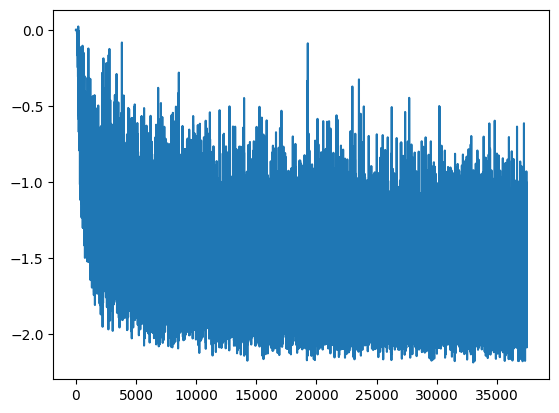

In [6]:
import matplotlib.pyplot as plt

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
epochs = 10
batch_size = 16

ds_load = torch.utils.data.TensorDataset(*train_data)
dl = torch.utils.data.DataLoader(dataset=ds_load, batch_size=batch_size, shuffle=True, drop_last=True)

ls,t = np.zeros(epochs*(N//batch_size)),0
for i in range(epochs):
    for batch in dl:
        optimizer.zero_grad()
        loss = model.training_step([xj.unsqueeze(1) for xj in batch], batch_idx=t) 
        loss.backward()
        optimizer.step()
        ls[t] = loss.detach().numpy()
        t+=1
    print('epoch #' + str(i+1) + '/' + str(epochs) + ', loss : ' + str(ls[t-1]))
plt.plot(ls)
plt.show()


## evaluate classification of digits on held-out test data

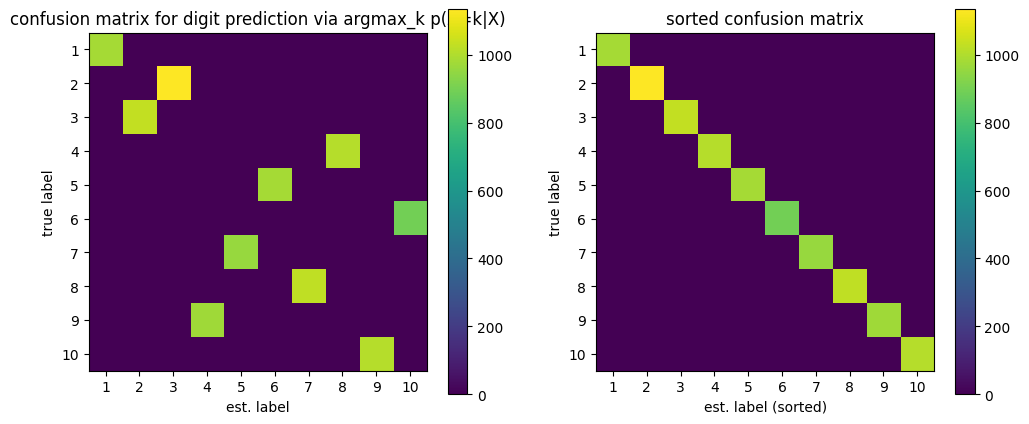

In [7]:
from sklearn import metrics as skmetrics
import scipy

plt.figure(figsize=(12,5))

posts = torch.exp(model.eval([td.unsqueeze(1) for td in test_data])[1]).detach().numpy()
MAP = np.argmax(posts,axis=1)

M0 = skmetrics.confusion_matrix(y_true=test_labels, y_pred=MAP)
plt.subplot(1,2,1)
plt.imshow(M0)
plt.ylabel('true label')
plt.xlabel('est. label')
plt.xticks(np.arange(10), np.arange(10)+1)
plt.yticks(np.arange(10), np.arange(10)+1)
plt.colorbar()
plt.title('confusion matrix for digit prediction via argmax_k p(Z=k|X)')

# sort latent states to align with digits 1,...,10 by sorting confusion matrix
_, idx_class_align = scipy.optimize.linear_sum_assignment(-M0.T)
MAP_aligned = idx_class_align[MAP]

# plot sorted confusion matrix
M = skmetrics.confusion_matrix(y_true=test_labels, y_pred=MAP_aligned)    
plt.subplot(1,2,2)
plt.imshow(M)
plt.title('sorted confusion matrix')
plt.ylabel('true label')
plt.xlabel('est. label (sorted)')
plt.xticks(np.arange(10), np.arange(10)+1)
plt.yticks(np.arange(10), np.arange(10)+1)
plt.colorbar()
plt.show()